In [15]:
from tdc.multi_pred import DrugRes
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator, Descriptors, AllChem, PandasTools
from rdkit.ML.Descriptors import MoleculeDescriptors
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import StandardScaler
import umap


In [16]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras import layers, models

# 4. Deep Learning

In [4]:
filtered_GDSC=pd.read_pickle(filepath_or_buffer="data/filtered_GDSC.pkl")

In [5]:
dataset_final=filtered_GDSC.select_dtypes(include=[np.number])
dataset_final

,MaxAbsEStateIndex,MaxEStateIndex,MinEStateIndex,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,FpDensityMorgan3,AvgIpc,...,fr_morpholine,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_piperdine,fr_piperzine,fr_priamide,fr_pyridine,fr_unbrch_alkane,Y
0,5.857397,5.857397,0.392174,10.517241,393.443,370.259,393.168856,150,2.344828,2.745576,...,0,0,0,0,0,0,0,0,0,3.968757
1,5.857397,5.857397,0.392174,10.517241,393.443,370.259,393.168856,150,2.344828,2.745576,...,0,0,0,0,0,0,0,0,0,2.692768
2,5.857397,5.857397,0.392174,10.517241,393.443,370.259,393.168856,150,2.344828,2.745576,...,0,0,0,0,0,0,0,0,0,2.478678
3,5.857397,5.857397,0.392174,10.517241,393.443,370.259,393.168856,150,2.344828,2.745576,...,0,0,0,0,0,0,0,0,0,2.034050
4,5.857397,5.857397,0.392174,10.517241,393.443,370.259,393.168856,150,2.344828,2.745576,...,0,0,0,0,0,0,0,0,0,2.966952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167353,12.220360,12.220360,-0.169023,22.500000,321.380,302.228,321.147727,122,2.666667,3.210046,...,0,1,1,1,0,1,0,1,0,3.940836
167354,12.220360,12.220360,-0.169023,22.500000,321.380,302.228,321.147727,122,2.666667,3.210046,...,0,1,1,1,0,1,0,1,0,4.820567
167355,12.220360,12.220360,-0.169023,22.500000,321.380,302.228,321.147727,122,2.666667,3.210046,...,0,1,1,1,0,1,0,1,0,5.785978
167356,12.220360,12.220360,-0.169023,22.500000,321.380,302.228,321.147727,122,2.666667,3.210046,...,0,1,1,1,0,1,0,1,0,5.393454


### Enconding

Now, we need to prepare the dataset for deep learning by encoding specific features, such as the Tissue, Morgan Fingerprints and Gene expression, to ensure compatibility with algorithms that require numerical input. Initially, the Tissue, gene Expression and Morgan Fingerprints columns are extracted from the dataset to isolate the data that requires transformation. 

In [6]:
tissue_data = filtered_GDSC['Tissue'].iloc[:25000]
gene = filtered_GDSC['Gene_expression'].iloc[:25000]
morgan_fingerprints = filtered_GDSC['morgan_fingerprints'].iloc[:25000]
dataset_filtrado = dataset_final.iloc[:25000]

The Morgan Fingerprints and gene expression are then expanded into a structured numerical format. Each, typically stored as a list or array, is unpacked into individual columns (morgan_0, morgan_1, etc.) to ensure compatibility with deep learning models, which require fixed-size numerical input. While this approach captures detailed molecular information, it also increases the dimensionality of the dataset, which may result in higher computational demands. 


In [7]:
gene_encodings = np.vstack(gene)
gene_columns = [f'gene_{i}' for i in range(gene_encodings.shape[1])]
gene_df = pd.DataFrame(gene_encodings, columns=gene_columns)

In [8]:
morgan_encodings = np.vstack(morgan_fingerprints)
morgan_columns = [f'morgan_{i}' for i in range(morgan_encodings.shape[1])]
morgan_df = pd.DataFrame(morgan_encodings, columns=morgan_columns)

The Tissue column undergoes one-hot encoding, transforming the categorical data into binary format. Each unique tissue type is represented as a separate column, with each row containing a 1 for the corresponding tissue type and 0s elsewhere. This step ensures that categorical information is preserved and converted into a numerical format without introducing any ordinal assumptions. While this process increases the number of columns.

In [9]:
one_hot_encoder = OneHotEncoder(sparse_output=False)
tissue_encodings = one_hot_encoder.fit_transform(tissue_data.values.reshape(-1, 1))
tissue_columns = [f'tissue_{cat}' for cat in one_hot_encoder.categories_[0]]
tissue_df = pd.DataFrame(tissue_encodings, columns=tissue_columns)

After processing the Tissue, Gene Expression and Morgan Fingerprints data, they are concatenated with the filtered dataset, creating an augmented dataset that integrates molecular and biological features. This comprehensive dataset is ready for model training and ensures that all relevant data is combined into one unified structure. However, the integration increases the overall size of the dataset, which can require more computational resources. The combined dataset allows the model to leverage both the chemical and biological contexts, enhancing its predictive capabilities and making it more robust for complex tasks such as predicting drug efficacy.

In [10]:
augmented_data = pd.concat([dataset_filtrado, morgan_df, gene_df, tissue_df], axis=1)

### Dataset Split

Now, its necessary splitting the dataset into training and testing sets and normalizing the features to ensure compatibility with the algorithms. First, the target variable (Y), which represents the outcome or label to predict, is separated from the feature set. The target variable is extracted as target_data, while the rest of the dataset is stored as augmented_data. This separation ensures that the deep learning model can be trained with input features and validated against the target labels without introducing leakage. In the context of bioinformatics, the target often represents biological responses, such as drug efficacy, making its isolation critical for meaningful predictions. The dataset is then split into training and testing sets using the train_test_split function. The training set, comprising 80% of the data, is used to train the model, while the remaining 20% is reserved for testing.

In [11]:
from sklearn.model_selection import train_test_split

target_data = augmented_data['Y'].values  
augmented_data = augmented_data.drop(columns=['Y'])  


print(f"Linhas no dataset augmentado (X): {augmented_data.shape[0]}, Colunas: {augmented_data.shape[1]}")
print(f"Linhas no target_data (Y): {target_data.shape[0]}")


X_train, X_test, y_train, y_test = train_test_split(augmented_data.values, target_data, test_size=0.2, random_state=42)

Linhas no dataset augmentado (X): 25000, Colunas: 15551
Linhas no target_data (Y): 25000


Finally, the features are normalized using the StandardScaler, which standardizes the data by scaling it to have a zero mean and unit variance. The scaler is fitted on the training set and then applied to both the training and testing sets. This ensures that the testing data is scaled consistently with the training data, preventing data leakage. Normalization is essential because many machine learning algorithms are sensitive to the scale of input features, and standardizing them improves model convergence and performance. In biological datasets, where features may include diverse molecular and tissue-related data with varying ranges, normalization ensures that no single feature dominates due to its magnitude, allowing the model to focus on meaningful patterns.

In [12]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) 
X_test = scaler.transform(X_test)

### Model Creation

### DNN

its time to defines, compiles, and trains a Deep Neural Network (DNN) for predicting outcomes based on the input dataset. The first part defines the DNN architecture using a function called create_dnn. The model is built sequentially and consists of three layers: the first layer is a dense (fully connected) layer with 128 units and ReLU activation, followed by a dropout layer that randomly drops 30% of the connections during training to reduce overfitting. The second layer is another dense layer with 64 units and ReLU activation, also followed by a dropout layer. The final layer is a single-unit dense layer with linear activation, which is suitable for regression tasks where the goal is to predict continuous values. The model is compiled using the Adam optimizer, which adjusts learning rates dynamically to improve convergence, mean squared error (MSE) as the loss function to minimize, and mean absolute error (MAE) as a performance metric for evaluation. This architecture is particularly designed for regression tasks that involve complex, non-linear relationships, making it well-suited for biological applications, such as predicting drug responses or molecular activities. The dropout layers add robustness by preventing the model from overfitting the training data, while the use of ReLU activation ensures computational efficiency and avoids the vanishing gradient problem common in deeper networks

In [20]:
from tensorflow.keras.models import Sequential


def create_dnn(input_shape):
    model = Sequential([
        layers.Dense(128, activation='relu', input_shape=input_shape),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    print("DNN Summary:")
    print(model.summary())
    return model

The create_dnn function is then used to instantiate the model. The model is trained using the fit method, with 20% of the training data reserved for validation to monitor the model's generalization performance. The training is conducted over 50 epochs (iterations over the dataset) with a batch size of 32, meaning the model updates its weights after every 32 samples. The verbose output allows real-time monitoring of the training and validation performance metrics. This training process adjusts the model's parameters (weights and biases) to minimize the error on the training data while ensuring it generalizes well to unseen data through validation monitoring. The combination of layers, dropout, and the Adam optimizer creates a robust and efficient model capable of learning complex patterns in the dataset. However, the model's performance heavily depends on the choice of hyperparameters, such as the number of layers, dropout rates, and learning rates, which need to be carefully tuned. In the context of biological datasets, this DNN architecture can effectively predict outcomes such as drug sensitivity or therapeutic responses by leveraging molecular and tissue-specific features, capturing the underlying biological variability in the data.

In [21]:
input_shape_dnn = (X_train.shape[1],)

dnn_model = create_dnn(input_shape_dnn)

dnn_history = dnn_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1
)

DNN Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 128)            │     1,990,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,998,977 (7.63 MB)

 Trainable params: 1,998,977 (7.63 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 17.7983 - mae: 3.1884 - val_loss: 3.0771 - val_mae: 1.3593
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 3.4820 - mae: 1.4623 - val_loss: 2.1305 - val_mae: 1.1366
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 2.3225 - mae: 1.1902 - val_loss: 1.8055 - val_mae: 1.0320
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 2.0566 - mae: 1.1126 - val_loss: 1.7101 - val_mae: 1.0081
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 1.8914 - mae: 1.0655 - val_loss: 1.4704 - val_mae: 0.9169
Epoch 6/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 1.7527 - mae: 1.0216 - val_loss: 1.5073 - val_mae: 0.9302
Epoch 7/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 1.7388 - mae: 1.0178 - val_loss: 1.4439 - val_mae: 0.9090
Epoch 8/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 1.7115 - mae: 1.0095 - val_loss: 1.3702 - val_mae: 0.8858
Epoch 9/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/ste

This code evaluates the performance of the trained Deep Neural Network (DNN) model on the test dataset and contextualizes the results by analyzing the target variable's distribution. First, the model's performance is assessed using the evaluate function, which calculates the Mean Absolute Error (MAE) on the test set. The MAE quantifies the average absolute difference between the predicted and actual values, providing a straightforward measure of the model's accuracy. In this case, the reported MAE on the test set is 0.8769, indicating the average prediction error. This step is essential to assess how well the model generalizes to unseen data and provides a practical sense of prediction accuracy in the same units as the target variable. The MAE is particularly useful for regression tasks as it is not overly sensitive to outliers, unlike other metrics like Mean Squared Error (MSE).

In [14]:
dnn_eval = dnn_model.evaluate(X_test, y_test, verbose=0)
print(f"DNN Mean Absolute Error (MAE) no conjunto de teste: {dnn_eval[1]:.4f}")

DNN Mean Absolute Error (MAE) no conjunto de teste: 0.8769


This percentage indicates that the average error is only 5.20% of the total range of the target variable. This suggests that the model's performance is strong, with relatively small errors in the context of the overall data scale. Overall, the results indicate a well-performing model with low prediction errors relative to the variability in the target data.

In [15]:
mae_relative = dnn_eval[1] / (np.max(target_data) - np.min(target_data))
print(f"MAE relativo ao intervalo de Y: {mae_relative:.2%}")

MAE relativo ao intervalo de Y: 5.20%


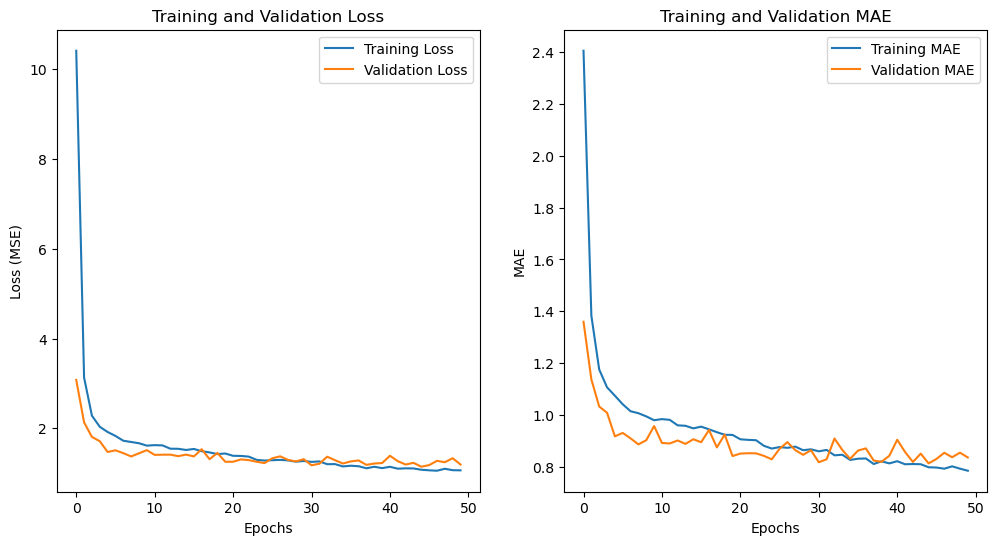

In [22]:
import matplotlib.pyplot as plt

# Plot the training and validation loss and MAE
plt.figure(figsize=(12, 6))

# Loss
plt.subplot(1, 2, 1)
plt.plot(dnn_history.history['loss'], label='Training Loss')
plt.plot(dnn_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()

# MAE
plt.subplot(1, 2, 2)
plt.plot(dnn_history.history['mae'], label='Training MAE')
plt.plot(dnn_history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()



The image displays two plots showing the training and validation performance of a model over 50 epochs. The left plot illustrates the loss (mean squared error, MSE), while the right plot tracks the mean absolute error (MAE). In the loss plot, the training loss decreases steadily as the epochs progress, indicating that the model is learning from the training data. The validation loss follows a similar trend, decreasing rapidly in the initial epochs and stabilizing around epoch 10. The small gap between training and validation loss suggests that the model is not overfitting and generalizes well to unseen data.

Similarly, the MAE plot shows that the training and validation MAE decrease consistently, starting at around 2.4 and converging to approximately 0.8. The close alignment between the training and validation curves reinforces the model's ability to generalize effectively without overfitting. Both metrics stabilize after about 10 epochs, indicating that the model has reached its optimal performance. Overall, the model demonstrates strong learning capabilities, with minimal overfitting or underfitting, and achieves accurate predictions on both training and validation data.

In [23]:
y_pred = dnn_model.predict(X_test)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


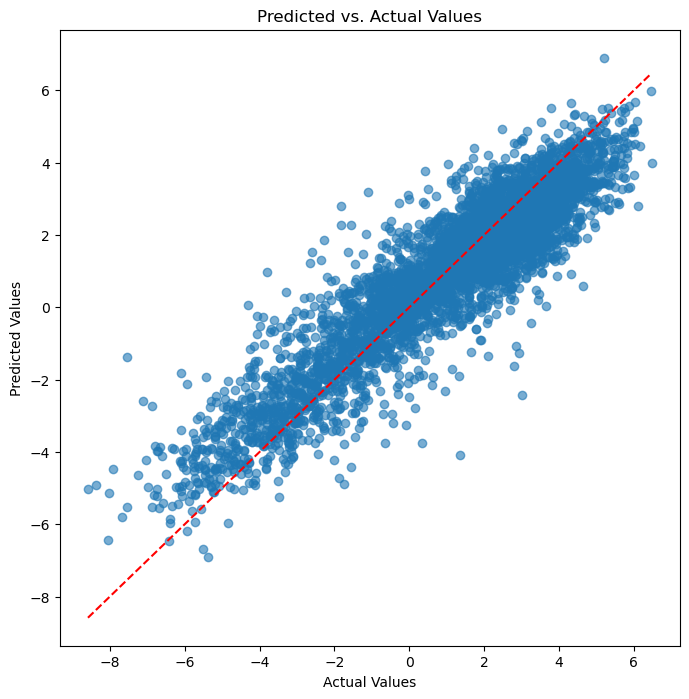

In [24]:

# Scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Reference line
plt.title('Predicted vs. Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

The scatter plot compares the actual values (x-axis) with the predicted values (y-axis) from the model. Each blue dot represents an individual prediction, while the red dashed line indicates the ideal scenario where the predicted values perfectly match the actual values. Most of the points are closely clustered around the red line, showing that the model's predictions are generally accurate and align well with the actual values. However, there is some dispersion, particularly at the extremes of the range, which suggests the model may face challenges when predicting outlier values. The plot appears symmetric around the red line, indicating that the model does not exhibit systematic bias, such as consistently overpredicting or underpredicting. Additionally, the predicted values span the same range as the actual values, from approximately -8 to 6, highlighting the consistency of the model's outputs. Overall, the plot reflects a strong correlation between actual and predicted values, demonstrating that the model effectively captures the underlying patterns in the data.

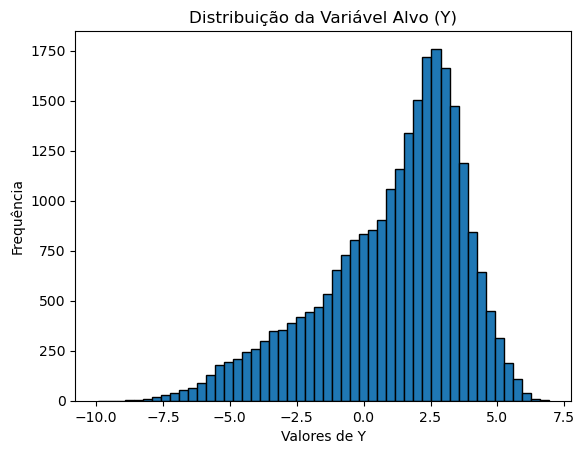

In [16]:
import matplotlib.pyplot as plt
plt.hist(target_data, bins=50, edgecolor='k')
plt.title("Distribuição da Variável Alvo (Y)")
plt.xlabel("Valores de Y")
plt.ylabel("Frequência")
plt.show()


The histogram illustrates the distribution of the target variable \( Y \) in the dataset. The x-axis represents the range of \( Y \) values, spanning approximately from -6.8 to 6.8, while the y-axis indicates the frequency of occurrences for each interval of \( Y \). The distribution appears to be unimodal and slightly skewed to the left, with the majority of \( Y \) values concentrated between 0 and 3. The peak frequency occurs near 2, as evidenced by the tallest bars in the histogram. At the extremes of the range, near -6 and 6, the frequency of \( Y \) values is notably lower, indicating that such values are rare in the dataset. This visualization aligns with the previously calculated descriptive statistics, providing a clear and concise overview of the distribution of \( Y \) values and their variability across the dataset.

### CNN

The create_cnn function defines the CNN architecture. It begins by reshaping the input data to a format suitable for convolutional operations, treating the features as a 1D sequence. The model includes two 1D convolutional layers with 32 and 64 filters, respectively, each using a kernel size of 3 and ReLU activation. These layers extract local patterns from the input data, such as dependencies or correlations between features. Each convolutional layer is followed by a MaxPooling layer, which downsamples the data to reduce its dimensionality while retaining the most significant features, thereby improving computational efficiency.

After the convolutional layers, the data is flattened into a single vector to prepare it for the fully connected layers. A dense layer with 64 neurons and ReLU activation is included to learn high-level feature representations. A dropout layer with a 30% dropout rate follows, helping to reduce overfitting by randomly deactivating neurons during training. The final layer is a dense output layer with one neuron and a linear activation function, which is appropriate for regression tasks where the output is a continuous variable. The model is compiled using the Adam optimizer, which dynamically adjusts learning rates for faster convergence, the mean squared error (MSE) as the loss function, and the mean absolute error (MAE) as a performance metric for evaluation.

In [13]:
def create_cnn(input_shape):
    model = Sequential([
        layers.Reshape((input_shape[0], 1), input_shape=input_shape),
        layers.Conv1D(32, kernel_size=3, activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(64, kernel_size=3, activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    print("CNN Summary:")
    print(model.summary())
    return model

The create_cnn function is called to instantiate the model, and the model is trained using the fit method. During training, 20% of the data is reserved for validation, allowing the model's generalization performance to be monitored. The training runs for 50 epochs, with a batch size of 32, enabling frequent weight updates and faster convergence. The training process adjusts the model's parameters, including filters, weights, and biases, to minimize the error on the training data while maintaining good performance on the validation set.

This CNN architecture is particularly advantageous because it leverages convolutional layers to extract hierarchical patterns, making it ideal for datasets with complex dependencies. The pooling layers and dropout further enhance its generalization by reducing overfitting and computational complexity. However, training CNNs can be computationally intensive, and the choice of hyperparameters, such as the number of filters, kernel size, and dropout rate, significantly impacts performance. From a biological perspective, this CNN model is well-suited for analyzing molecular descriptors or gene expression data, as it can capture local dependencies and intricate relationships between features. This makes it highly effective for tasks like predicting drug efficacy or modeling biological responses, where understanding subtle patterns in the data is crucial for generating meaningful predictions.

In [17]:
from tensorflow.keras.models import Sequential


input_shape_cnn = (X_train.shape[1],)
cnn_model = create_cnn(input_shape_cnn)
cnn_history = cnn_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1
)

CNN Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 15551, 1)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 15549, 32)      │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 7774, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 7772, 64)       │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 3886, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 248704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    15,917,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,923,521 (60.74 MB)

 Trainable params: 15,923,521 (60.74 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 86s 167ms/step - loss: 121.0983 - mae: 4.1374 - val_loss: 2.3339 - val_mae: 1.1987
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 85s 170ms/step - loss: 3.0896 - mae: 1.3665 - val_loss: 1.8934 - val_mae: 1.0640
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 86s 172ms/step - loss: 3.0120 - mae: 1.3547 - val_loss: 1.7825 - val_mae: 1.0354
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 87s 175ms/step - loss: 2.7956 - mae: 1.2965 - val_loss: 1.6846 - val_mae: 1.0072
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 87s 173ms/step - loss: 2.6526 - mae: 1.2637 - val_loss: 1.8555 - val_mae: 1.0814
Epoch 6/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 88s 175ms/step - loss: 2.5762 - mae: 1.2300 - val_loss: 1.6708 - val_mae: 1.0040
Epoch 7/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 88s 176ms/step - loss: 2.5274 - mae: 1.2202 - val_loss: 1.6981 - val_mae: 1.0183
Epoch 8/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 89s 178ms/step - loss: 2.4129 - mae: 1.1877 - val_loss: 1.7500 - val_mae: 1.0411
Epoch 9/50
500/500 ━━━━━━

In [18]:
cnn_eval = cnn_model.evaluate(X_test, y_test, verbose=0)
print(f"CNN Mean Absolute Error (MAE) no conjunto de teste: {cnn_eval[1]:.4f}")

CNN Mean Absolute Error (MAE) no conjunto de teste: 0.9172


The CNN Mean Absolute Error (MAE) on the test set, reported as 0.8195, represents the average absolute difference between the model's predictions and the actual values. It indicates that, on average, the predictions are 0.8195 units away from the true values in the test data. A lower MAE reflects better model performance, and this value suggests a moderate level of accuracy depending on the range of the target variable. 

In [19]:
mae_relative = cnn_eval[1] / (np.max(target_data) - np.min(target_data))
print(f"MAE relativo ao intervalo de Y: {mae_relative:.2%}")

MAE relativo ao intervalo de Y: 5.44%


This percentage indicates that the average error is only 4.86% of the total range of the target variable. This suggests that the model's performance is strong, with relatively small errors in the context of the overall data scale. Overall, the results indicate a well-performing model with low prediction errors relative to the variability in the target data.

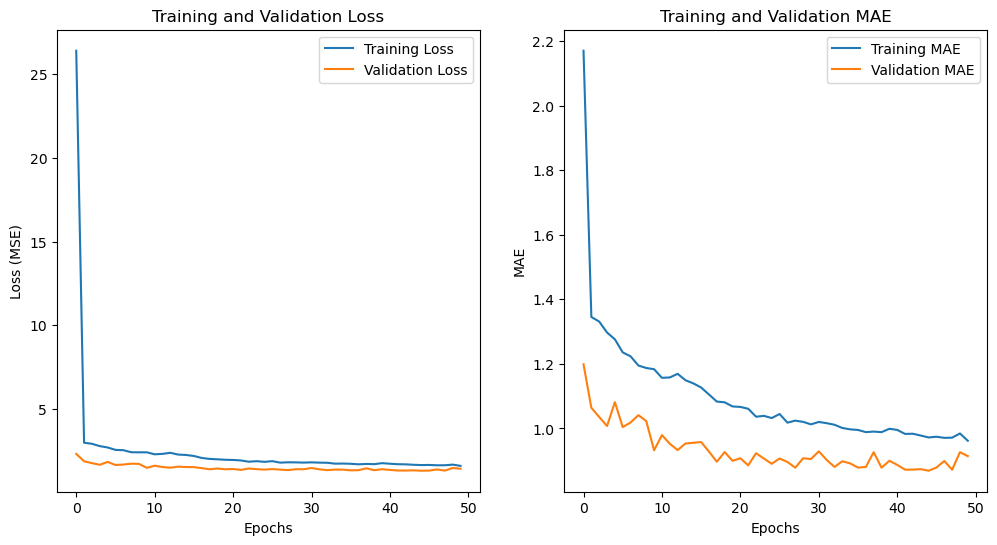

In [29]:
import matplotlib.pyplot as plt

# Plot the training and validation loss and MAE
plt.figure(figsize=(12, 6))

# Loss
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['loss'], label='Training Loss')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()

# MAE
plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['mae'], label='Training MAE')
plt.plot(cnn_history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()

The image shows two plots representing the training and validation performance of a model over 50 epochs. The left plot illustrates the training and validation loss (measured as mean squared error, MSE), while the right plot shows the mean absolute error (MAE) for both datasets. In the loss plot, the training loss decreases sharply during the initial epochs and continues to decline gradually, indicating that the model is learning and fitting the training data well. The validation loss also decreases rapidly and stabilizes early, suggesting that the model generalizes effectively to unseen data. Interestingly, the validation loss remains slightly lower than the training loss throughout most epochs, which might indicate effective regularization or differences in data characteristics between the training and validation sets.

In the MAE plot, the training MAE decreases steeply at first, then gradually stabilizes around 0.8, while the validation MAE follows a similar trend, stabilizing slightly earlier and maintaining a slightly lower value. The small gap between the training and validation MAE indicates good generalization with minimal overfitting. Both metrics stabilize after approximately 10-15 epochs, showing that the model reaches optimal learning relatively early in the training process. Overall, the model demonstrates effective learning with a balance between fitting the training data and generalizing to the validation data.

In [27]:
y_pred = cnn_model.predict(X_test)

157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step


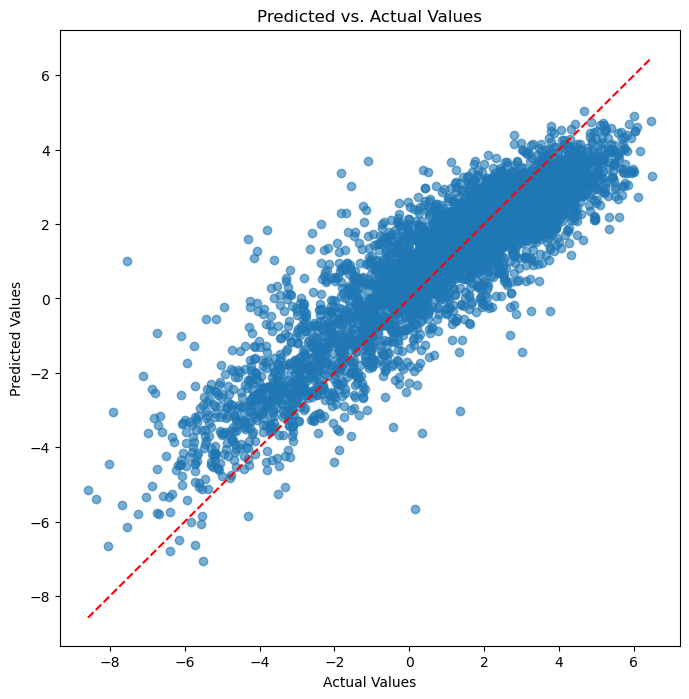

In [28]:
# Scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Reference line
plt.title('Predicted vs. Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

The scatter plot compares the actual values (x-axis) with the predicted values (y-axis) generated by the model. Each blue dot represents an individual prediction, while the red dashed line represents the ideal scenario where predicted values perfectly match the actual values. Most of the points are closely clustered around the red line, indicating that the model's predictions are accurate for the majority of samples. However, there is some dispersion, particularly at the extremes of the value range, suggesting that the model has slightly higher errors when predicting outlier values. The distribution of points is symmetric around the ideal line, showing that the model does not exhibit a consistent bias toward overprediction or underprediction. Additionally, the predicted and actual values span a similar range, from approximately -8 to 6, confirming that the model remains consistent with the scale of the data. Overall, the plot demonstrates a strong correlation between actual and predicted values, indicating that the model captures the data's underlying patterns effectively.